# Watershed

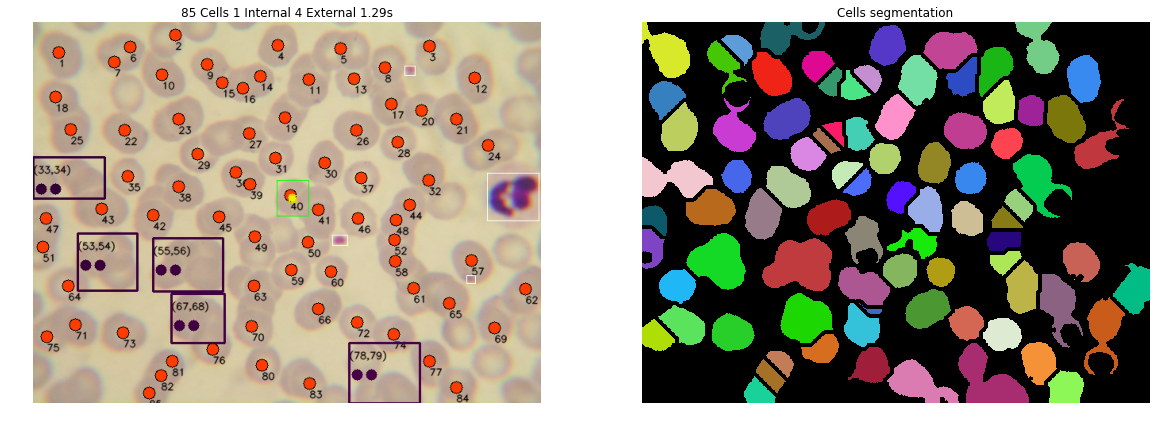

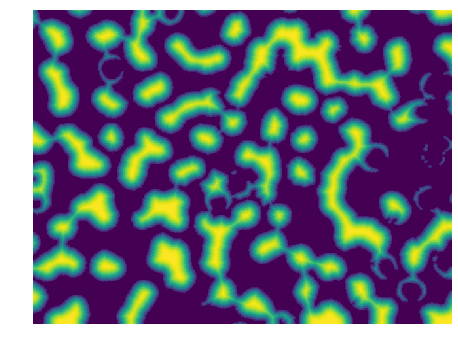

In [3]:
from ipynb.fs.full.general_functions import *

#https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html#sphx-glr-auto-examples-segmentation-plot-watershed-py
#https://docs.opencv.org/4.5.3/dd/d49/tutorial_py_contour_features.html

from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import imutils
from skimage import measure
from skimage.segmentation import random_walker

MAX_CELL_AREA = 2700


def applyWatershed(cell_mask):
    D = ndimage.distance_transform_edt(cell_mask)
    
    localMax = peak_local_max(D, min_distance=10, 
                                  #threshold_rel=0,
                                  #exclude_border=True,
                                  threshold_abs=10, 
                                  labels=cell_mask)
    
    peak_mask = np.zeros_like(cell_mask, dtype=bool)
    peak_mask[tuple(localMax.T)] = True
    
    
    
    numLabels, labels, stats, centroids = [], [], [], []
    

    markers = ndimage.label(peak_mask, structure=np.ones((3, 3)))[0]
    labels = watershed(-D, markers, mask=cell_mask,watershed_line=True)
    
    watershed_lines = np.zeros(shape=np.shape(labels),dtype='uint8')
    watershed_lines[labels==0] = 1 # ws lines are labeled as 0 in markers
    watershed_lines = dilate(watershed_lines,2)
    
    new = np.ones(labels.shape,dtype='uint8')
    new -= watershed_lines
    
    labeled, numLabels, labels, stats, centroids = connected_components(new)
    labeled = shuffle_colors(labeled)
    labeled = np.uint8(labeled);
    
    
    newLabels = []
    i = 0
    for label in np.unique(labels):
        
        m = (labels == label)  # boolean array/mask of pixels with this label
        newLabel = np.zeros((labeled.shape[0],labeled.shape[1]),dtype='uint8')
        newLabel[m] = 255
        
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        
        newLabel = newLabel[y:y+h, x:x+w]
        newLabels.append(newLabel)
        i += 1
        
    #remove o background dos components
    numLabels -= 1
    newLabels  = newLabels[1:]
    stats      = stats[1:]
    centroids  = centroids[1:]
    
    return (labeled, numLabels, newLabels, stats, centroids), D


def watershed_method(path, validation_type, mark_parasites=True):

    start = time.time()

    #read in grayscale
    imgGS = get_image(path=path)
    #read in colors
    img = get_image(path=path,mode=1)


    imgB = cv2.pyrMeanShiftFiltering(img, 3, 10)
    imgGS = cv2.cvtColor(imgB,cv2.COLOR_RGB2GRAY)

    #otsu adaptative
    #cell_mask = otsu(imgGS)
    #cell_mask = cv2.adaptiveThreshold(imgGS, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51, 2.5)
    #cell_mask = cv2.adaptiveThreshold(imgGS,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,15,0)
    
    cell_mask = cv2.adaptiveThreshold(imgGS, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 301, 0)
        
    
    #hsv parasite mask
    par_mask, par_mask_dilated = hsv_par_mask(img)

    #remove parasites from otsu
    cell_mask = remove_parasites(cell_mask,par_mask)

    #fill holes
    cell_mask = fill_holes(cell_mask)

    # watershed
    components, D = applyWatershed(cell_mask)
    labels = components[0]

    img, cells = mark_cells(img, mask=None, components=components,validation_type=validation_type)
    if mark_parasites:
        img, internal, external = parasites_mark(img, par_mask, None, components)
    else:
        internal, external = 0,0

    end = time.time()
    passTime = "%.2fs" % (end-start)
    #save results
    save_results(path, "Watershed" ,cells,internal,external, passTime, img, "_waterhshed", validation_type)

    return (img, labels, D), (cells,internal,external,passTime)

if __name__ == '__main__':

    #PATH = "../PHOTOS_MALARIA_VHIR_UPC/fotos_2015_12_01/P_falciparum/Trofozoits/DSCN0083.JPG"
    #PATH = "../blood_samples/samples/blood_smear_2.JPG"
    #PATH = "../blood_samples/samples/blood_smear_1.JPG"
    #PATH = "../blood_samples/samples/blood_smear_14.JPG"
    PATH = "../blood_samples/samples/blood_smear_8.JPG"
    images, stats = watershed_method(PATH, NO_VALIDATION)
    img, labels, D = images
    cells, internal, external, passTime = stats

    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].imshow(img)
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(labels, cmap='nipy_spectral', interpolation='nearest')
    ax[1].set_title("Cells segmentation")
    plt.show()

    plt.figure(figsize=(7.5,7.5))
    plt.imshow(cv2.equalizeHist(D.astype('uint8')), interpolation='nearest')
    plt.show()


